In [1]:
#Importing Libraries
import saha_mult
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
import importlib 
importlib.reload(saha_mult)

<module 'saha_mult' from '/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py'>

In this document, I do many things regarding abundances.The first thing I do is read in data for the NIST table, where I was able to extract ionization potentials from Hydrogen to Lawrencium. Although the NIST table has data for all elements up to element 110, DarmStadtium, elements between 104 to 110 are missing many values, so I did not include them. I also extracted data taken from Skynet through an hdf5 file.

I test the Samarium abundances by comparing the data for Samarium using the saha.mult class to the data from the one element case, and the result was that the data was exactly the same. This is just as predicted.

I then implemented a two element scenario, where I calculated and graphed the relative abundances of all charge states for both my test elements, which are Samarium and Europium.

From there, I graphed both relative abundances to see all the unique charge states and how they should add up to 1. As a check, I also calculated the sum of the Sm and Eu relative abundances, compared it to the total relative abundance of 1, and then graphed it to see a straight line, which makes sense.

From here on,which is 1/22/2020, I will create a function that takes in skynet data and ionization potentials to calculate all the abundances. I will have to check why it takes a long time to do all the abundance calculations and plot all the results, which are all the graphs presented within this Jupyter notebook. Also, I will need to adjust the temperature calculations by reducing the uncertainty in my slope used to extrapolate the temperatures. Finally, it is important to use unique values of the initial parameters in Skynet to get different data in order to see how much the Ye affects everything.

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#Showing us how the data looks like
nist.head(50)

,At. Num.,Sp. Name.,Ion Charge,El. name,Isoel. Seq.,Ground Shells a,Ground Level,Ionized Level (eV),Ionization Energy (eV),Uncertaintyc,References
0,1,H I,0,Hydrogen,H,1s,2S1/2,,-13.5984,8e-08,HDEL
1,2,He I,0,Helium,He,1s2,1S0,1s 2S1/2,24.5874,1.5e-07,L17714
2,2,He II,1,Helium,H,1s,2S1/2,,-54.4178,3e-07,L7188c95
3,3,Li I,0,Lithium,Li,1s22s,2S1/2,1s2 1S0,5.39171,4e-08,L12261
4,3,Li II,1,Lithium,He,1s2,1S0,1s 2S1/2,[75.6400964],1.3e-06,L10054
5,3,Li III,2,Lithium,H,1s,2S1/2,,-122.454,8e-07,L3620c96
6,4,Be I,0,Beryllium,Be,1s22s2,1S0,2s 2S1/2,9.3227,7e-06,L5964
7,4,Be II,1,Beryllium,Li,1s22s,2S1/2,1s2 1S0,18.2111,4e-05,L12158
8,4,Be III,2,Beryllium,He,1s2,1S0,1s 2S1/2,[153.896203],4e-06,L10054
9,4,Be IV,3,Beryllium,H,1s,2S1/2,,-217.719,1.7e-06,L3620c97


In [5]:
#This cell puts all the ionization potentials into an array of arrays. I had to take out the NIST data as well
#Note that indices in this code represents the Z of the element, so H has an index of 1 for its ionization potentials
#Note that the first thing inside this array is empty or NaN
ion_energies1d =  nist[' Ionization  Energy (eV)']
max_el = 104 #This is defined to be the Z of the last element that I want in the list +1. Ex. Lr + 1 = 104
ion_energies = list()
counter = 0

for i in range(0,max_el):
    specific_list = list()
    
    for j in range(i):
        
        if isinstance(ion_energies1d[counter],str):
            
            if len(ion_energies1d[counter]) ==3:
                specific_list.append(0)
                counter+=1
            else:
                str_num = '' 

                for k in ion_energies1d[counter]:

                    if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                        str_num+=k
                        
                specific_list.append(np.abs(float(str_num)))
                counter+=1
                
                            
        else:
            specific_list.append(np.abs(ion_energies1d[counter]))
            counter+=1
        
    ion_energies.append(specific_list)



In [6]:
#Showing how the ionization_potential array looks
ion = pd.DataFrame(ion_energies)
ion

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.598434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24.587389,54.417765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.391715,75.640096,122.454358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.322699,18.211150,153.896203,217.718584,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,6.367580,12.200000,22.700000,38.800000,54.1,71.0,97.0,112.9,137.0,157.0,...,37400.0,38100.0,38900.0,39451.4,154328.1,156926.0,NaN,NaN,NaN,NaN
100,6.500000,12.400000,23.200000,39.300000,55.0,74.0,93.0,120.0,136.0,162.0,...,31800.0,38400.0,39100.0,40000.0,40482.2,158152.5,160804.0,NaN,NaN,NaN
101,6.580000,12.400000,24.300000,40.000000,54.1,76.0,96.0,115.1,143.9,162.0,...,32000.0,32500.0,39500.0,40100.0,41000.0,41548.0,0.0,164764.0,NaN,NaN
102,6.626210,12.930000,25.800000,41.500000,60.0,74.0,97.0,119.0,140.0,170.0,...,32200.0,32700.0,33200.0,40500.0,41200.0,42100.0,42632.0,0.0,168806.0,NaN


In [8]:
#This calculates the temperature values through extrapolations. I have not yet implemented an averaging over the temperature or time
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []
m = (np.log10(temperature[1700]) - np.log10(temperature[1600])) / (np.log10(time[1700]) - np.log10(time[1600]))
for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])
        

In [24]:
#This cell is designed to read in the data and to find the abundances of just samarium within the skynet data
abundance = hf["Y"]
charge = hf["Z"]
index_list = []
full_abundance = []
density = hf["Density"]
ion_potential = ion_energies[62:63]
kbEvpGK = 8.617e-5*1e9

for i in range(len(charge)):
    if charge[i] == 62: ##charge of samarium
        index_list.append(i)
        
full_abundance = np.sum(abundance[:, index_list], 1)

In [10]:
#I use the saha_mult class to run the getAbundances() method in order to get the Samarium Abundances
#I am testing whether the multiple element solution works for just Samarium so I can compare this to the single element case
YI = saha_mult.GetAbundances(full_abundance,np.array(full_temp),np.array(density),np.array(ion_potential))


/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:109: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:110: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:121: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


Text(0, 0.5, 'Abundance')

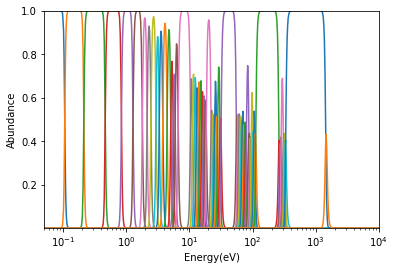

In [11]:
#Here, I am plotting the abundances of Samarium vs temperature. This graph is eqiuvalent to the data from the single element case
#Make a note that the structure of this YI is multidimensional, with a shape of (1,2198,N=Z)
Ytot = np.sum(YI[0],1)
for i in range(len(ion_potential[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot[0])

plt.ylim([1.e-5, 1])
plt.xlim([0.05, 1e4])
plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")


In [12]:
#Here, I convert the abundances of Samarium to a pandas dataframe to see the table in a table
Y = pd.DataFrame(YI[0])
Y

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
2,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
3,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
4,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,4.627743e-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2194,4.627743e-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2195,4.627743e-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2196,4.627743e-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [32]:
#This is just extracting the total Samarium and Europium abundances from Skynet.
#I also set up the ionization energies arrays for both elements here

index_listSm = []
index_listEu = []

full_abundanceSm = []
full_abundancesEu = []

Z1 = 62
Z2 = 63
ion_potential = [ion_energies[Z1], ion_energies[Z2]]

for i in range(len(charge)):
    if charge[i] == Z1: ##charge of samarium
        index_listSm.append(i)
        
for i in range(len(charge)):
    if charge[i] == Z2: ##charge of europium
        index_listEu.append(i)
        
full_abundanceSm = np.sum(abundance[:, index_listSm], 1)
full_abundanceEu = np.sum(abundance[:, index_listEu], 1)

full_list_abun = np.vstack((full_abundanceSm,full_abundanceEu))


In [33]:
#Getting abundances for Eu and Sm 
YI = saha_mult.GetAbundances(full_list_abun,np.array(full_temp),np.array(density),np.array(ion_potential))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


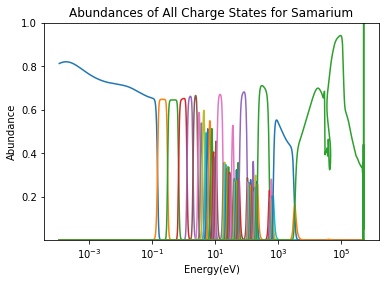

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


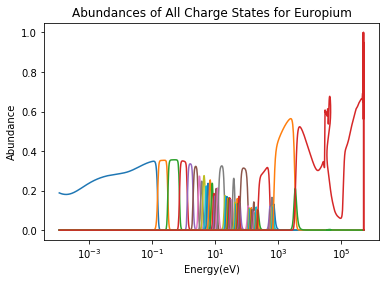

In [35]:
#Getting plot for Eu and Sm
#Note that the shape of the abundance arrays is one more than the Z because it also accounts for fully ionized
Ytot = np.sum(YI[0],1) + np.sum(YI[1],1)

for i in range(len(ion_potential[0])+1):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot)
plt.ylim([1.e-10, 1])  
plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")
plt.title("Abundances of All Charge States for Samarium")
plt.show()

for i in range(len(ion_potential[1])+1):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[1][:,i])/Ytot)

plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")
plt.title("Abundances of All Charge States for Europium")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


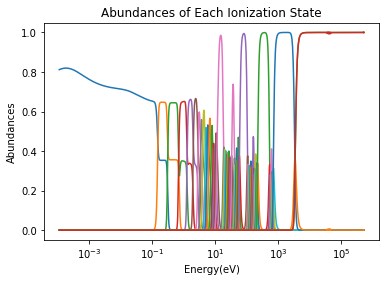

In [36]:
#This graph will show which charge abundances dominate as a function of temperature
#Note that there will be a peak of charge abundance that only has Europium since Samarium is one less.
#I think this will only be 63 peaks and not 64 peaks
for i in range(len(ion_potential[0])+1):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i] + YI[1][:,i+1])/Ytot)
plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,-1] + YI[1][:,-1])/Ytot)   
plt.xlabel("Energy(eV)")
plt.ylabel("Abundances")
plt.title("Abundances of Each Ionization State")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


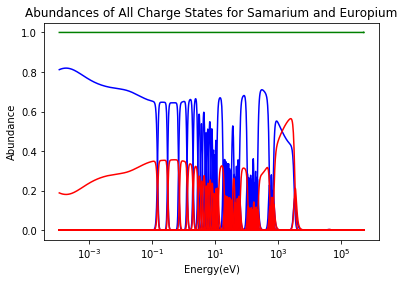

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


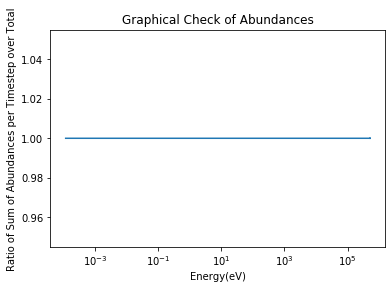

In [19]:
#These two graphs are to check whether the data adds to 1
#The first is just showing both plots on the same graph with a value of 1 at the top
#The second plot is a ratio of the sum of the relative abundances to the total

for i in range(len(ion_potential[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot,color = 'b')
    
for i in range(len(ion_potential[1])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[1][:,i])/Ytot,color = 'r')

plt.semilogx(kbEvpGK*np.array(full_temp),Ytot/Ytot,color = 'g')  

plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")
plt.title("Abundances of All Charge States for Samarium and Europium")
plt.show()

'''for i in range(len(ion_potential[0])):
    plt.semilogx(kbEvpGK*np.array(full_temp),(YI[0][:,i])/Ytot + (YI[1][:,i])/Ytot)
    
plt.xlabel("Energy(eV)")
plt.ylabel("Abundance")
plt.title("Abundances of All Charge States for Samarium + Europium")
plt.show()'''

checksum = []
for i in range(len(YI[0])):
    checksum.append(np.sum(YI[0][i]) + np.sum(YI[1][i]))
(plt.semilogx(kbEvpGK*np.array(full_temp),checksum/Ytot))
plt.xlabel("Energy(eV)")
plt.ylabel("Ratio of Sum of Abundances per Timestep over Total")
plt.title("Graphical Check of Abundances")
plt.show()

In [20]:
#I am visualizing the Samarium Data through a table
Sm = pd.DataFrame(YI[0])
Sm

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733025e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869509e-129,6.890581e-120,9.733026e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427886e-147,3.439394e-138,4.869510e-129,6.890581e-120,9.733026e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427887e-147,3.439394e-138,4.869510e-129,6.890582e-120,9.733027e-111,1.373940e-101,1.937976e-92,2.732131e-83,3.560009e-74,4.627743e-65
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.427887e-147,3.439395e-138,4.869511e-129,6.890583e-120,9.733029e-111,1.373940e-101,1.937976e-92,2.732132e-83,3.560010e-74,4.627744e-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,0.000070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2194,0.000070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2195,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2196,0.000069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [37]:
#I am visualizing the Europium data in a table
Eu = pd.DataFrame(YI[1])
Eu

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.958755e-151,9.850464e-142,1.393563e-132,1.970423e-123,2.780803e-114,3.921951e-105,5.526981e-96,7.784693e-87,1.010677e-77,1.308969e-68
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.958755e-151,9.850465e-142,1.393563e-132,1.970423e-123,2.780803e-114,3.921951e-105,5.526981e-96,7.784693e-87,1.010677e-77,1.308969e-68
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.958755e-151,9.850465e-142,1.393563e-132,1.970423e-123,2.780803e-114,3.921951e-105,5.526981e-96,7.784694e-87,1.010677e-77,1.308969e-68
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.958756e-151,9.850466e-142,1.393563e-132,1.970424e-123,2.780804e-114,3.921951e-105,5.526982e-96,7.784694e-87,1.010677e-77,1.308969e-68
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.958757e-151,9.850467e-142,1.393563e-132,1.970424e-123,2.780804e-114,3.921952e-105,5.526982e-96,7.784695e-87,1.010677e-77,1.308969e-68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2194,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2195,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2196,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
